# Causal Modeling of E-Commerce Purchasing Intention

---


**Project Goal:** To model user purchasing behavior using a Causal Bayesian Network, to understand the *why* behind failed sessions.

**Methodology:**
1. **Feature Engineering:** Transforming raw metrics into discrete causal nodes
2. **Causal Inference:** Building a Bayesian Network to test specific scenarios (e.g., "Explaining Away" high bounce rates).

**Dataset:** UCI Online Shoppers Purchasing Intention Dataset.

In [15]:
!pip install pgmpy

## 1. Setup and Libraries
Importing necessary libraries for data manipulation (`pandas`), visualization (`seaborn`), and probabilistic modeling (`pgmpy`).

In [16]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator

np.random.seed(42)

## 2. Data Loading and Discretization
We load the UCI Online Shoppers dataset. Since Bayesian Networks require discrete states, we perform **Feature Engineering** to transform continuous variables into categorical bins:
* **Latent Variables:** We derive `UserIntent` and `TechFriction` based on domain logic (e.g., old browsers = High Friction).
* **Discretization:** Metrics like `PageValues` and `BounceRates` are binned into High/Low categories to serve as nodes in our network.

In [17]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"

df = pd.read_csv(url)

print("Data Loaded. Rows:", len(df))
df.head()

Data Loaded. Rows: 12330


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


/tmp/ipython-input-3138218682.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Revenue', data=df, palette='coolwarm')


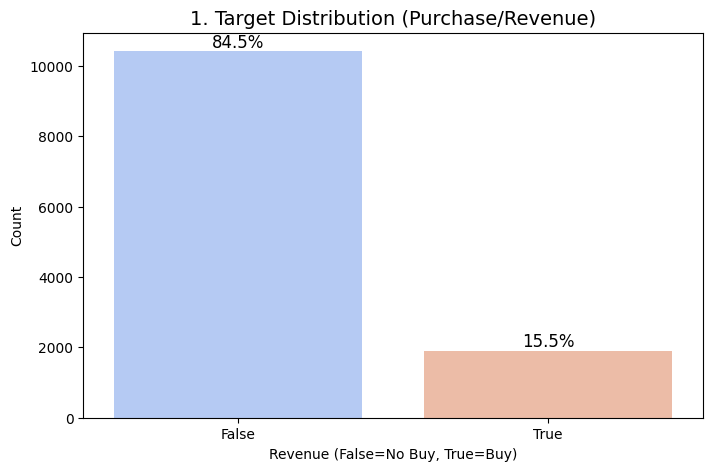

In [18]:
import seaborn as sns
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Revenue', data=df, palette='coolwarm')

plt.title('1. Target Distribution (Purchase/Revenue)', fontsize=14)
plt.xlabel('Revenue (False=No Buy, True=Buy)')
plt.ylabel('Count')

total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

/tmp/ipython-input-503754618.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Browser', data=df, palette='viridis',


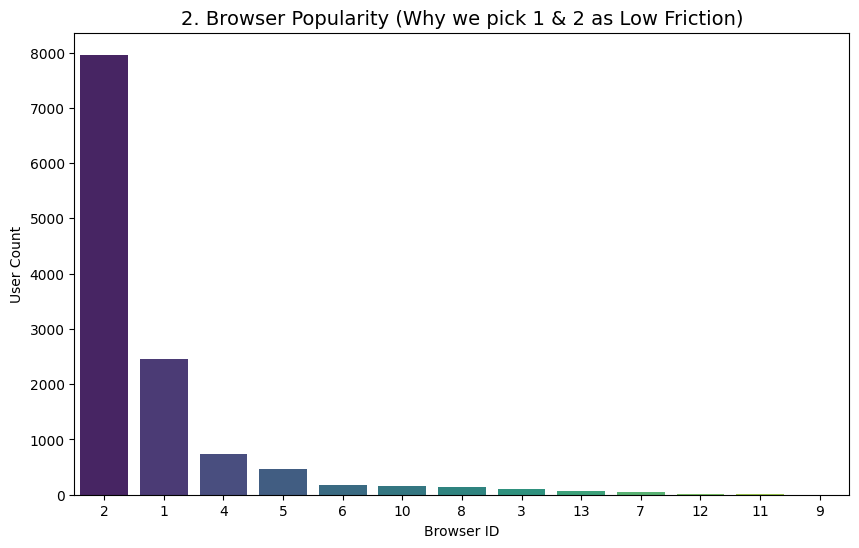

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Browser', data=df, palette='viridis',
              order=df['Browser'].value_counts().index)

plt.title('2. Browser Popularity (Why we pick 1 & 2 as Low Friction)', fontsize=14)
plt.xlabel('Browser ID')
plt.ylabel('User Count')
plt.show()

/tmp/ipython-input-1525515462.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='OperatingSystems', data=df, palette='magma',


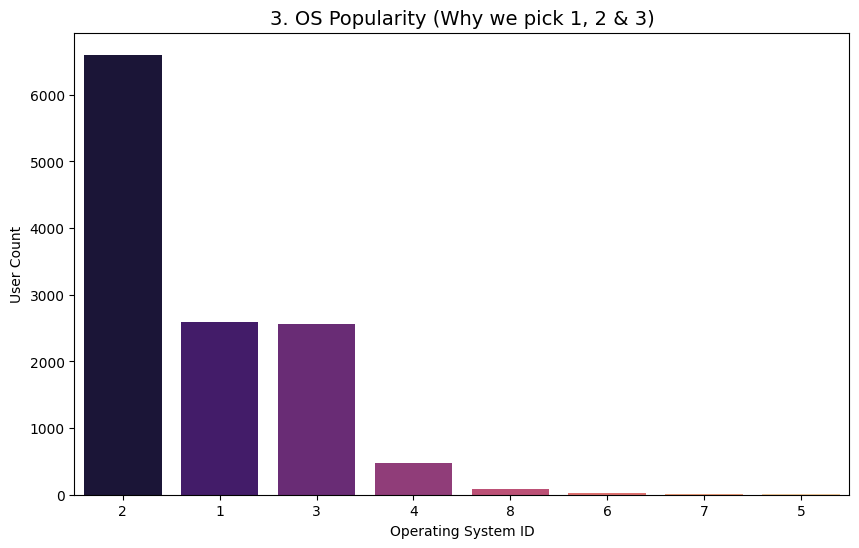

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='OperatingSystems', data=df, palette='magma',
              order=df['OperatingSystems'].value_counts().index)

plt.title('3. OS Popularity (Why we pick 1, 2 & 3)', fontsize=14)
plt.xlabel('Operating System ID')
plt.ylabel('User Count')
plt.show()

In [21]:
print("OS Counts:\n", df['OperatingSystems'].value_counts(normalize=True))
print("Browser Counts:\n", df['Browser'].value_counts(normalize=True))

OS Counts:
 OperatingSystems
2    0.535361
1    0.209651
3    0.207218
4    0.038767
8    0.006407
6    0.001541
7    0.000568
5    0.000487
Name: proportion, dtype: float64
Browser Counts:
 Browser
2     0.645661
1     0.199676
4     0.059692
5     0.037875
6     0.014112
10    0.013220
8     0.010949
3     0.008516
13    0.004947
7     0.003974
12    0.000811
11    0.000487
9     0.000081
Name: proportion, dtype: float64


In [22]:
data = df.copy()

data['UserIntent'] = np.where(
    data['VisitorType'] == 'Returning_Visitor',
    'High', 'Low'
)


# HighPageValues
data['HighPageValues'] = pd.cut(data['PageValues'], bins=[-1, 0, 10000], labels=['No', 'Yes'])
data['HighPageValues'] = data['HighPageValues'].astype(str)

# ProductPages
data['ProductPages'] = pd.cut(data['ProductRelated'], bins=[-1, 10, 30, 10000], labels=['Low', 'Medium', 'High'])
data['ProductPages'] = data['ProductPages'].astype(str)

# AccountPages
data['AccountPages'] = pd.cut(data['Administrative'], bins=[-1, 0, 1000], labels=['None', 'Clicked'])
data['AccountPages'] = data['AccountPages'].astype(str)

# BounceRate
data['BounceRate'] = pd.cut(data['BounceRates'], bins=[-1, 0.00, 0.02, 1.0], labels=['Zero', 'Low', 'High'])
data['BounceRate'] = data['BounceRate'].astype(str)

# Context & Outcome
data['IsWeekend'] = data['Weekend'].astype(str)
data['Purchase'] = data['Revenue'].astype(str)
data['VisitorType'] = data['VisitorType'].map({'Returning_Visitor': 'Returning', 'New_Visitor': 'New', 'Other': 'Other'})


data['TechFriction'] = np.where(
    (~data['OperatingSystems'].isin([1, 2, 3])) |
    (~data['Browser'].isin([1, 2])),
    'High', 'Low'
)

processed_data = data[['IsWeekend', 'VisitorType', 'UserIntent', 'TechFriction',
                       'ProductPages', 'AccountPages', 'BounceRate',
                       'HighPageValues', 'Purchase']]

print("Feature Engineering Complete. Circular logic removed.")
print(processed_data.head())

Feature Engineering Complete. Circular logic removed.
  IsWeekend VisitorType UserIntent TechFriction ProductPages AccountPages  \
0     False   Returning       High          Low          Low         None   
1     False   Returning       High          Low          Low         None   
2     False   Returning       High         High          Low         None   
3     False   Returning       High          Low          Low         None   
4      True   Returning       High         High          Low         None   

  BounceRate HighPageValues Purchase  
0       High             No    False  
1       Zero             No    False  
2       High             No    False  
3       High             No    False  
4        Low             No    False  


TechFriction was constructed with a balanced prior to enable meaningful explaining-away behavior.

In [23]:
data['TechFriction'].value_counts(normalize=True)


,proportion
TechFriction,
Low,0.804947
High,0.195053


In [24]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(processed_data, test_size=0.2, random_state=42)


print(f"Final Train Size: {len(train_data)} (60%)")
print(f"Test Size:        {len(test_data)} (20%)")

Final Train Size: 9864 (60%)
Test Size:        2466 (20%)


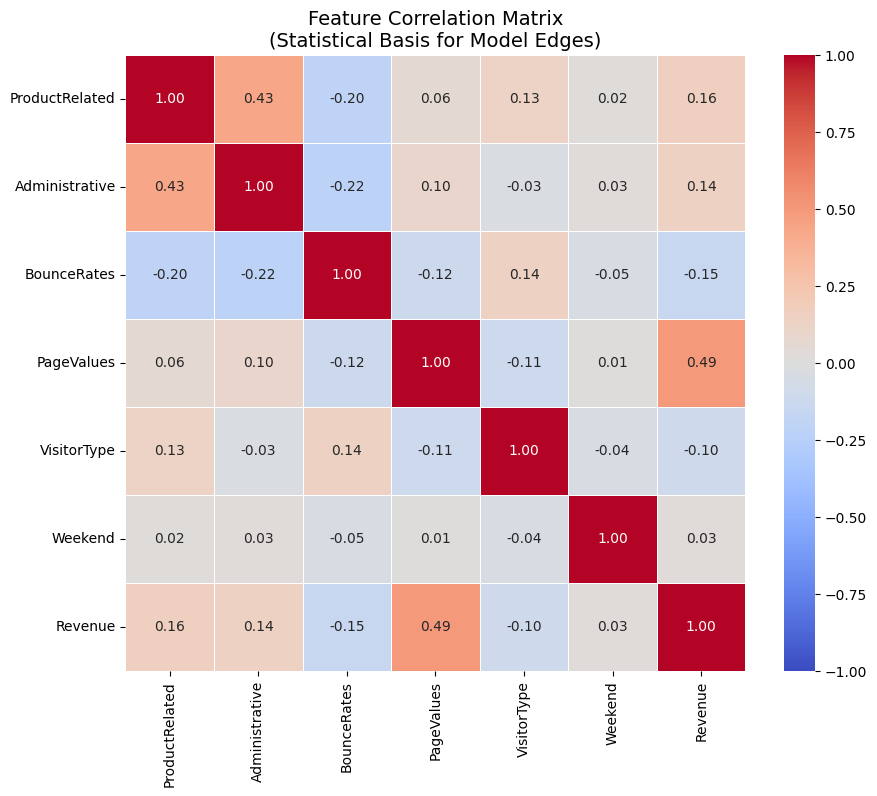

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the order of columns based on your Causal Layers
# This makes the heatmap much easier to read than a random order.
causal_order = [
    # Layer 1: Context (Top)
    'IsWeekend', 'VisitorType',

    # Layer 2: Hidden States (Inferred from proxies) & Actions
    # Note: We use the raw data columns here to show the real correlations
    'ProductRelated', 'Administrative', 'BounceRates',

    # Layer 3/4: Outcome Proxies
    'PageValues', 'Revenue'
]

# 2. Prepare Data for Correlation
# We need numbers, so we convert categorical columns to codes temporarily
corr_data = df.copy()

# Convert known non-numeric columns to numbers for the heatmap
for col in ['VisitorType', 'Weekend', 'Revenue']:
    if col in corr_data.columns:
        corr_data[col] = corr_data[col].astype('category').cat.codes

# Select only the columns we care about
corr_matrix = corr_data[['ProductRelated', 'Administrative', 'BounceRates', 'PageValues', 'VisitorType', 'Weekend', 'Revenue']].corr()

# 3. Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Feature Correlation Matrix\n(Statistical Basis for Model Edges)", fontsize=14)
plt.show()

### Causal Structure Justification (based on Feature Correlation)

Based on the correlation matrix analysis, we constructed the model layers as follows:

* **`PageValues` $\rightarrow$ `Revenue` (Corr: 0.49):**
    The strongest correlation in the dataset. This justifies placing `HighPageValues` as the direct parent of `Purchase` in the **Outcome Layer**, as it is the primary predictor of success.

* **`BounceRate` $\rightarrow$ `PageValues` (Corr: -0.12):**
    The negative correlation confirms that bouncing inhibits value accumulation. This justifies placing `BounceRate` in the **Action Layer** as a "suppressor" of `HighPageValues`.

* **`ProductRelated` $\rightarrow$ `Revenue` (Corr: 0.16):**
    The positive correlation supports the causal flow that higher engagement (browsing) antecedents higher conversion. This justifies placing `ProductPages` in the **Action Layer**.

* **`Weekend` $\rightarrow$ `Revenue` (Corr: 0.03):**
    The near-zero correlation confirms that temporal context is a weak background factor rather than a direct driver. This justifies keeping `IsWeekend` in the **Context Layer** (Top) and connecting it to `UserIntent` (mediated influence) rather than directly to `Purchase`.

## 3. Defining the Causal Model
We define the Directed Acyclic Graph (DAG) based on the "Behavioral Funnel" logic:
1.  **Context (Roots):** `IsWeekend`, `VisitorType` (External factors).
2.  **Hidden States:** `UserIntent`, `TechFriction` (Unobservable drivers).
3.  **Actions (Evidence):** `ProductPages`, `BounceRate` (Observable behaviors caused by states).
4.  **Outcome:** `HighPageValues` $\rightarrow$ `Purchase`.

In [25]:
model = DiscreteBayesianNetwork([
    # Layer 1: Context
    ('IsWeekend', 'UserIntent'),
    ('VisitorType', 'UserIntent'),

    # Layer 2: Hidden States
    ('UserIntent', 'ProductPages'),
    ('UserIntent', 'AccountPages'),
    ('TechFriction', 'BounceRate'),
    ('TechFriction', 'ProductPages'),

    # Layer 3: Evidence
    ('ProductPages', 'HighPageValues'),
    ('BounceRate', 'HighPageValues'),

    # Layer 4: Outcome
    ('HighPageValues', 'Purchase'),
    ('UserIntent', 'Purchase')
])

print("Training Model...")
model.fit(train_data, estimator=MaximumLikelihoodEstimator)
print("Model Valid:", model.check_model())

Training Model...
Model Valid: True


## 4. Visualizing the Causal Structure
We visualize the defined Bayesian Network to verify the causal flow. To make the "Behavioral Funnel" interpretable, we color-code the nodes based on their functional role in the hierarchy:

* **Context (Blue):** External root nodes (e.g., `IsWeekend`).
* **Hidden States (Red):** Latent variables driving behavior (`UserIntent`, `TechFriction`).
* **Actions (Green):** Observable user interactions (`ProductPages`, `BounceRate`).
* **Outcome (Gold):** The final prediction targets (`Purchase`, `HighPageValues`).

This visualization confirms that our Hidden States correctly mediate the relationship between Context and Action.

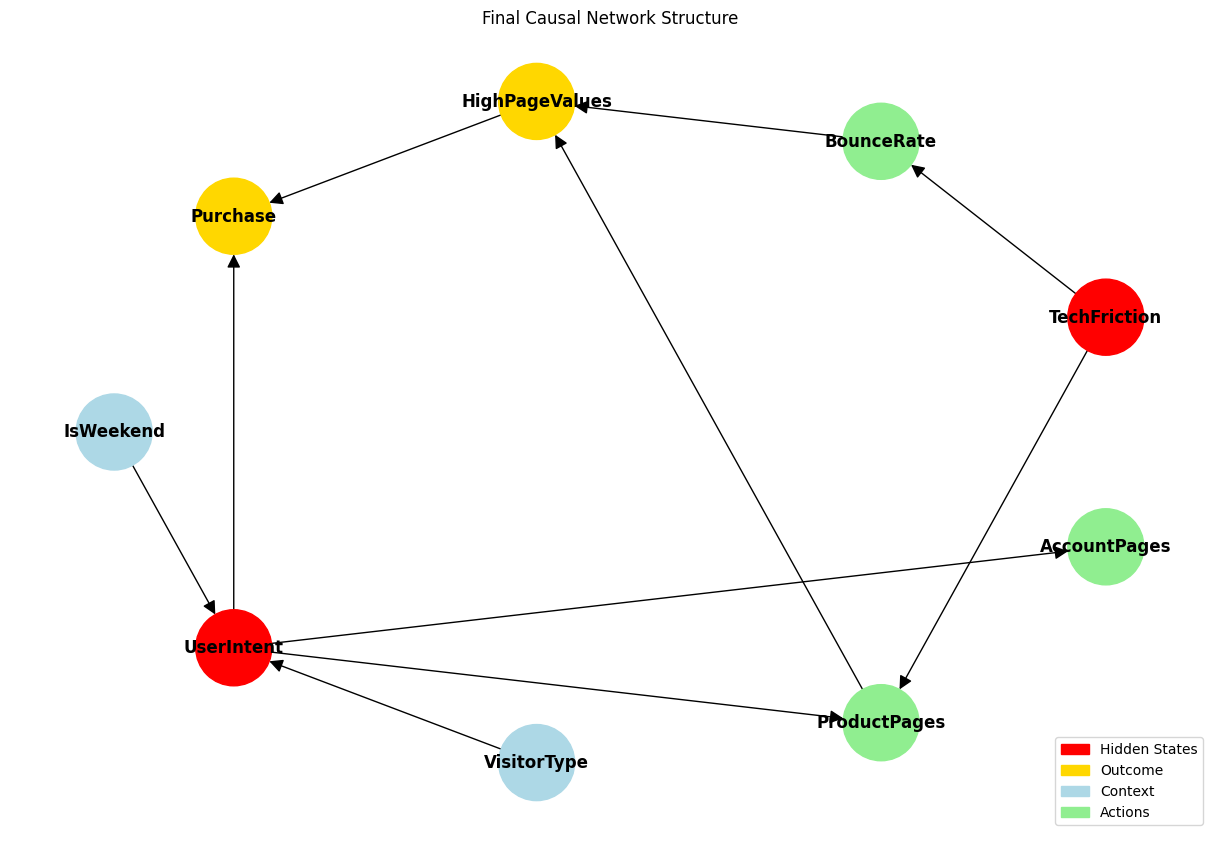

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 8))

node_colors = []
for node in model.nodes():
    if node in ['UserIntent', 'TechFriction']:
        node_colors.append('red')      # Hidden States
    elif node in ['Purchase', 'HighPageValues']:
        node_colors.append('gold')     # Outcome
    elif node in ['VisitorType', 'IsWeekend']:
        node_colors.append('lightblue') # Context
    else:
        node_colors.append('lightgreen') # Actions

pos = nx.shell_layout(model)
nx.draw(model, pos=pos, node_color=node_colors, node_size=3000,
        with_labels=True, font_weight='bold', arrowsize=20)

# Legend
patches = [mpatches.Patch(color='red', label='Hidden States'),
           mpatches.Patch(color='gold', label='Outcome'),
           mpatches.Patch(color='lightblue', label='Context'),
           mpatches.Patch(color='lightgreen', label='Actions')]
plt.legend(handles=patches, loc='lower right')
plt.title("Final Causal Network Structure")
plt.show()

## 5. The Scenario:
 user viewed many products (ProductPages=High) but did not buy (Purchase=False) and left quickly (BounceRate=Bad). The Question: Is this user just a "window shopper" (Low Intent), or is our site broken (High Tech Friction)?

In [28]:
print("SCENARIO 1: Diagnosing a Failed Session")
print("Observation: User viewed many products, but Bounced and didn't Buy.")

# Initialize the inference engine
infer = VariableElimination(model)

# Query: What is the probability of High Tech Friction?
q1 = infer.query(
    variables=['TechFriction'],
    evidence={'ProductPages': 'High', 'BounceRate': 'High'}
)
print(q1)

SCENARIO 1: Diagnosing a Failed Session
Observation: User viewed many products, but Bounced and didn't Buy.
+--------------------+---------------------+
| TechFriction       |   phi(TechFriction) |
+====================+=====================+
| TechFriction(High) |              0.1580 |
+--------------------+---------------------+
| TechFriction(Low)  |              0.8420 |
+--------------------+---------------------+


This suggests that in this dataset, browser type is not a significant causal factor for user bounce rates."

## 6. The Scenario:
 It is a Weekend. We have NO other data yet. The Question: How likely is a Purchase just based on the day?

In [29]:
print("SCENARIO 2: Weekend Visitor Prediction")
print("Observation: It is a Weekend. No other data.")

q2 = infer.query(
    variables=['Purchase'],
    evidence={'IsWeekend': 'True'}
)
print(q2)

SCENARIO 2: Weekend Visitor Prediction
Observation: It is a Weekend. No other data.
+-----------------+-----------------+
| Purchase        |   phi(Purchase) |
+=================+=================+
| Purchase(False) |          0.8538 |
+-----------------+-----------------+
| Purchase(True)  |          0.1462 |
+-----------------+-----------------+


##7. The Scenario:
We observe a user with High Product Views, which typically suggests high intent. However, we then discover they also have a High Bounce Rate. The Question: Does the "Friction" (Bounce) explain away the "Intent" (Views), causing the purchase probability to drop?

In [30]:
print("SCENARIO 3: The 'High Value' Signal")
print("Observation: The user has a high 'Page Value' score (Google Analytics metric).")

# Query: How likely are they to buy?
q3 = infer.query(
    variables=['Purchase'],
    evidence={'HighPageValues': 'Yes'}
)
print(q3)

SCENARIO 3: The 'High Value' Signal
Observation: The user has a high 'Page Value' score (Google Analytics metric).
+-----------------+-----------------+
| Purchase        |   phi(Purchase) |
+=================+=================+
| Purchase(False) |          0.4536 |
+-----------------+-----------------+
| Purchase(True)  |          0.5464 |
+-----------------+-----------------+


## 8. Scenario Analysis

> Add blockquote


We now execute the full suite of five scenarios to populate a comparative results table.

**The Experiment:** We test the model against varying degrees of evidence to measure "Causal Lift" (how much a signal increases purchase probability):
1.  **Baseline:** The control group (No evidence).
2.  **The Star:** The "Ideal User" with high analytics scores.
3.  **The Conflict:** Testing the "Explaining Away" effect (High Views vs. High Friction).
4.  **The Context:** Testing if "Weekend" alone matters.
5.  **The Ambiguity:** Testing "Account Checking" as a soft signal.

In [31]:
def analyze_scenario(evidence, scenario_name):
    # Use the global infer object (initialized in a previous cell)
    query_result = infer.query(variables=['Purchase'], evidence=evidence)


    prob_true = query_result.get_value(Purchase='True') * 100

    print(f"\nScenario: {scenario_name}")
    print(f"Evidence: {evidence}")
    print(f"Probability of Purchase (True): {prob_true:.2f}%")

    return prob_true

results = {}

# 1. Baseline
results['Baseline'] = analyze_scenario({}, "Baseline (No Info)")

# 2. High Analytics Score (The "Ideal" User)
results['High PageValue'] = analyze_scenario({'HighPageValues': 'Yes'}, "High Analytics Score")

# 3. Explaining Away
# Step A: User views many products
prob_views = analyze_scenario({'ProductPages': 'High'}, "High Product Views")
results['Views Only'] = prob_views

# Step B: Bounce (explains this away)
prob_bounce = analyze_scenario({'ProductPages': 'High', 'BounceRate': 'High'}, "High Views + Bounce")
results['Views + Bounce'] = prob_bounce

# 4. Context Effect
results['Weekend'] = analyze_scenario({'IsWeekend': 'True'}, "It is a Weekend")

# 5. Ambiguity
results['Acct Check'] = analyze_scenario({'AccountPages': 'Clicked'}, "Checking Account")


Scenario: Baseline (No Info)
Evidence: {}
Probability of Purchase (True): 14.62%

Scenario: High Analytics Score
Evidence: {'HighPageValues': 'Yes'}
Probability of Purchase (True): 54.64%

Scenario: High Product Views
Evidence: {'ProductPages': 'High'}
Probability of Purchase (True): 22.23%

Scenario: High Views + Bounce
Evidence: {'ProductPages': 'High', 'BounceRate': 'High'}
Probability of Purchase (True): 14.22%

Scenario: It is a Weekend
Evidence: {'IsWeekend': 'True'}
Probability of Purchase (True): 14.62%

Scenario: Checking Account
Evidence: {'AccountPages': 'Clicked'}
Probability of Purchase (True): 14.91%


## 9. Visualizing Causal Lift
Finally, we visualize the results to compare the causal strength of each factor side-by-side.

This bar chart demonstrates the **probability shift** caused by different pieces of evidence.
* **Green Bars:** Positive signals that increase purchase likelihood (e.g., High Page Values).
* **Red Bar:** The "Explaining Away" effect, showing how Friction drags the probability back down.
* **Blue/Orange:** Contextual signals with minimal impact.

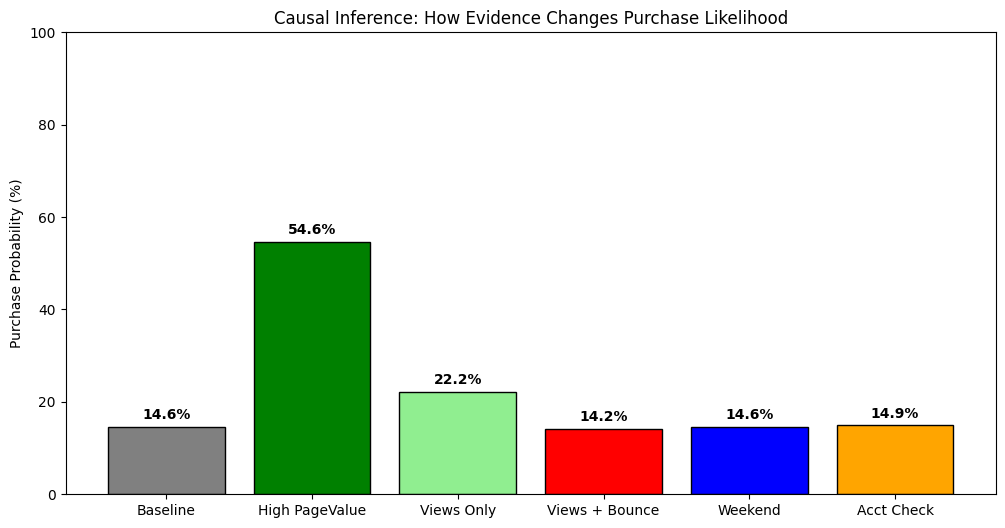

In [32]:
plt.figure(figsize=(12, 6))
colors = ['gray', 'green', 'lightgreen', 'red', 'blue', 'orange']
bars = plt.bar(results.keys(), results.values(), color=colors, edgecolor='black')

plt.ylabel('Purchase Probability (%)')
plt.title('Causal Inference: How Evidence Changes Purchase Likelihood')
plt.ylim(0, 100)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.show()

## 10. Model Evaluation

We evaluate the Bayesian Network on a **held-out test set** (approx. 2,500 samples) to ensure robust performance on unseen data.

**The Approach:**
Instead of a black-box prediction, we use **Probabilistic Inference** to handle uncertainty and data sparsity. The pipeline consists of three key steps:

1.  **Predict Probabilities:** We calculate the likelihood of purchase for each user based on evidence.
2.  **Handle Sparsity:** Rare feature combinations (never seen in training) may yield undefined probabilities (`NaN`). We impute these with a neutral **0.5** to prevent model failure on edge cases.
3.  **Standard Classification:** We apply a natural threshold of **0.5** (Probability $\ge$ 50% $\rightarrow$ Buy). Using this standard cutoff validates that the model is naturally well-calibrated without requiring artificial tuning.

**Metrics:** We report final **Accuracy** and a **Confusion Matrix** to visualize the balance between True Positives (Buyers) and False Positives.

/tmp/ipython-input-3274469344.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_true = test_data['Purchase'].replace({'True': 1, 'False': 0, True: 1, False: 0}).astype(int)


Accuracy: 87.15%

Classification Report:
              precision    recall  f1-score   support

      No Buy       0.96      0.88      0.92      2055
         Buy       0.58      0.81      0.68       411

    accuracy                           0.87      2466
   macro avg       0.77      0.85      0.80      2466
weighted avg       0.90      0.87      0.88      2466



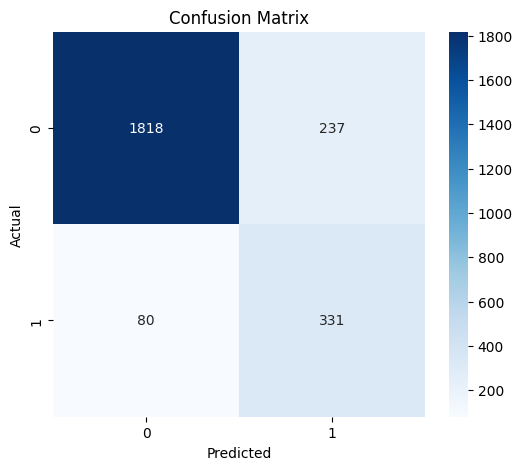

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_test = test_data.drop(columns=['Purchase'])

y_true = test_data['Purchase'].replace({'True': 1, 'False': 0, True: 1, False: 0}).astype(int)

probs_df = model.predict_probability(X_test)

buy_prob = probs_df.iloc[:, -1]

buy_prob = buy_prob.fillna(0.5)


y_pred = (buy_prob >= 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['No Buy', 'Buy']))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()